In [2]:
import hc_lib.plots.figlib as flib
flib.siteFG()
from figrid.figrid import DataList
from figrid.figrid import Figrid
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import illustris_python as il
PATH = '/lustre/cosinga/L75n1820TNG/output/'
data = il.groupcat.loadSubhalos(PATH, 99, fields = ['SubhaloStellarPhotometrics', 'SubhaloMassType'])
head = il.groupcat.loadHeader(PATH, 99)
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = 'dejavuserif'

/software/spack-software/2020.05.14/linux-rhel8-ivybridge/gcc-8.4.0/python-3.7.7-zgcjuclie3fiis4ljkrfp4c4j6fkoa62/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
ssp = 'SubhaloStellarPhotometrics'
gr = data[ssp][:, 4] - data[ssp][:, 5]
stmass = data['SubhaloMassType'][:,4]*1e10/head['HubbleParam']
mass = np.sum(data['SubhaloMassType'], axis = 1)
t = [2e8, np.max(stmass) + 1]
resolved_mask = (stmass > t[0]) & (stmass < t[1])


In [4]:
import h5py as hp
dustfile = hp.File('/lustre/cosinga/L75n1820TNG/postprocessing/stellar_light/Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc_099.hdf5', 'r')

photo = dustfile['Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc']

# using the axis to get the closest projection
proj = dict(photo.attrs)['projVecs']
los = np.zeros_like(proj)
los[:, 0] += 1

dist = np.sum((proj-los)**2, axis=1)
minidx = np.argmin(dist)

photo_dict = {}
photo_dict['gr'] = photo[:, 1, minidx] - photo[:, 2, minidx]
photo_dict['r'] = photo[:, 2, minidx]
photo_dict['i'] = photo[:, 3, minidx]
photo_dict['z'] = photo[:, 4, minidx]
photo_dict['g'] = photo[:, 1, minidx]
photo_dict['ri'] = photo_dict['r'] - photo_dict['i']
photo_dict['rz'] = photo_dict['r'] - photo_dict['z']
photo_dict['gi'] = photo_dict['g'] - photo_dict['i']

# these conversions are from Y. Xu et al. 2007
photo_dict['b_j'] = 0.15 + 0.13 * photo_dict['gr']
photo_dict['r_f'] = photo_dict['r'] - 0.13

dustfile.close()

/software/spack-software/2020.05.14/linux-rhel8-ivybridge/gcc-8.4.0/python-3.7.7-zgcjuclie3fiis4ljkrfp4c4j6fkoa62/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


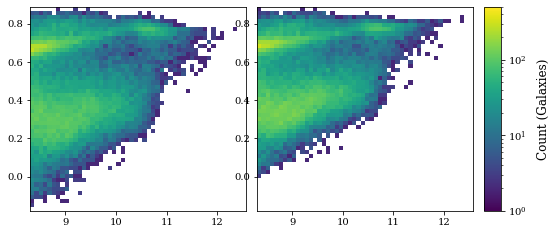

In [116]:
import copy
import seaborn as sb
cmap_name = 'viridis'
under_col = 'white'
logmass = np.log10(stmass)
logmass = logmass[resolved_mask]
fs = 12
figlen = 12
fig, axes = plt.subplots(1, 3, figsize = (figlen, figlen * 5/16), gridspec_kw = {'wspace':0.05})
bins = 50
hist, xedges, yedges = np.histogram2d(logmass, gr[resolved_mask], bins = bins, range = [np.log10(t), [np.min(gr[resolved_mask]), np.max(gr[resolved_mask])]])
dust, _, _ = np.histogram2d(logmass, photo_dict['gr'][resolved_mask], bins = bins, range = [np.log10(t), [np.min(gr[resolved_mask]), np.max(gr[resolved_mask])]])
hist = np.where(hist == 0, np.ones_like(hist) * 0.1, hist)
dust = np.where(dust == 0, np.ones_like(dust) * 0.1, dust)

norm = mpl.colors.LogNorm(vmin = 1, vmax = 500)
cmap = copy.copy(mpl.cm.get_cmap(cmap_name))
# cmap = sb.cubehelix_palette(start=-0.2, rot=-.6, as_cmap = True)
# cmap = mpl.colors.ListedColorMap(sb.color_palette('rocket', 256))
cmap.set_under(under_col)
# hist[hist < norm.vmin] = norm.vmin
# dust[dust < norm.vmin] = norm.vmin
axes[0].imshow(np.flipud(np.rot90(hist)), aspect = 'auto', origin = 'lower', extent = (xedges[0], xedges[-1], yedges[0], yedges[-1]), norm = norm, cmap = cmap)
axes[1].imshow(np.flipud(np.rot90(dust)), aspect = 'auto', origin = 'lower', extent = (xedges[0], xedges[-1], yedges[0], yedges[-1]), norm = norm, cmap = cmap)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap = cmap), cax = axes[2])
axes[2].set_aspect(12, anchor = 'W')

cbar.set_label('Count (Galaxies)', fontsize = fs, labelpad = 10)


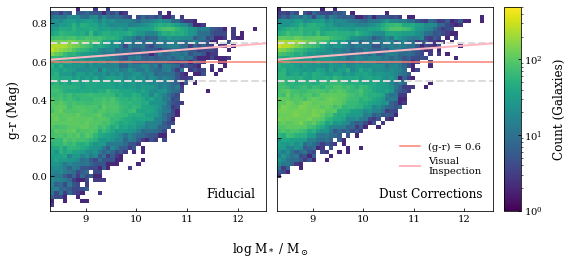

In [117]:
# plt.rcParams['legend.labelcolor'] = 'white'
fig.text(0.075, 0.5, 'g-r (Mag)', fontsize = fs, rotation = 'vertical', ha = 'left', va = 'center')
fig.text(0.38, -0.05, r'log M$_*$ / M$_\odot$', fontsize = fs, ha = 'center', va = 'bottom')
axes[1].tick_params(labelleft = False)
for i in range(3):
    axes[i].tick_params(direction = 'in')
def color(x):
    return 0.65 + 0.02 * (x - 10.28)
labs = ['Fiducial', 'Dust Corrections']
for i in range(2):
    p = axes[i]
    x = p.get_xlim()
    p.plot(x, [0.6, 0.6], color = 'salmon', label = '(g-r) = 0.6')
    p.plot(x, [0.5, 0.5], color = 'gainsboro', linestyle = '--', linewidth = 2)
    p.plot(x, [0.7, 0.7], color = 'gainsboro', linestyle = '--', linewidth = 2)
    xs = np.linspace(x[0], x[1])
    p.text(0.95, 0.05, labs[i], transform = p.transAxes, ha = 'right', va = 'bottom', fontsize= fs, color = 'black')
    p.plot(xs, color(xs), color = 'lightpink', label = 'Visual\nInspection',
          linewidth = 2)
axes[1].legend(frameon= False, loc = [0.55, 0.15], fontsize = fs - 2)
fig

In [118]:
fig.savefig('gr-stmass.pdf')


In [7]:
plt.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
        

In [8]:
axes[1].legend

<bound method Axes.legend of <matplotlib.axes._subplots.AxesSubplot object at 0x145ecf0e5f10>>

In [119]:
box = 'tng100'
snap = [99, 67]
axis = 0
res = 800
files = ['galaxygrid']
master = DataList()
for f in files:
    for s in snap:
        rlib = flib.load(box, s, axis, res, f, 'colordef')
        kmin = rlib.results['pk'][0].xvalues[0]
        BOX = rlib.results['pk'][0].props['box']
        RES = rlib.results['pk'][0].props['grid_resolution']
        master.loadResults(rlib.results['pk'])


box = 'tng100'
snap = [99, 67]
axis = 0
res = 800
files = ['galaxy_dustgrid']
master = DataList()
for f in files:
    for s in snap:
        rlib = flib.load(box, s, axis, res, f)
        print(rlib.results.keys())
        kmin = rlib.results['pk'][0].xvalues[0]
        BOX = rlib.results['pk'][0].props['box']
        RES = rlib.results['pk'][0].props['grid_resolution']
        master.loadResults(rlib.results['pk'])
        
smfont = 10
larfont = 12
cdict = flib.getCdict()
real_color = cdict['real']
redshift_color = cdict['redshift']
blue_color = cdict['blue']
red_color = cdict['red']
XBORDER, YBORDER = flib.getBorders()
XLIM = flib.getXlim()

dict_keys(['pk', 'slice', '2Dpk'])
dict_keys(['pk', 'slice', '2Dpk'])


In [151]:
fid = master.getMatching({'fieldname':'galaxy', 'color_cut':'0.60', 'snapshot':99})
print(len(fid))
bfid = fid[0].data
rfid = fid[1].data

blues = master.getMatching({'color':'blue', 'space':'real','snapshot':99})
bdata = {}
for b in blues:
    cc = b.attrs['color_cut']
    if not cc == '0.60' or b.attrs['fieldname'] == 'galaxy_dust':
        bdata[cc] = b.data[1] / bfid[1]

reds = master.getMatching({'color':'red', 'space':'real','snapshot':99})
rdata = {}
for b in reds:
    print(b.attrs)
    cc = b.attrs['color_cut']
    if not cc == '0.60' or b.attrs['fieldname'] == 'galaxy_dust':

        rdata[cc] = b.data[1] / rfid[1]

2
{'result_runtime': 44.4410400390625, 'is_auto': True, 'box': 75.0, 'simname': 'tng100', 'sim_resolution': 'high', 'num_part': 1733600704, 'grid_resolution': 800, 'snapshot': 99, 'redshift': 2.220446049250313e-16, 'axis': 0, 'fieldname': 'galaxy', 'is_hydrogen': False, 'is_atomic': False, 'is_molecular': False, 'is_particle': False, 'is_groupcat': True, 'is_matter': True, 'mas': 'CICW', 'space': 'real', 'compute_xi': False, 'compute_slice': True, 'color': 'red', 'gal_species': 'stmass', 'gal_res': 'diemer', 'color_cut': '0.50'}
{'result_runtime': 44.53453230857849, 'is_auto': True, 'box': 75.0, 'simname': 'tng100', 'sim_resolution': 'high', 'num_part': 1733600704, 'grid_resolution': 800, 'snapshot': 99, 'redshift': 2.220446049250313e-16, 'axis': 0, 'fieldname': 'galaxy', 'is_hydrogen': False, 'is_atomic': False, 'is_molecular': False, 'is_particle': False, 'is_groupcat': True, 'is_matter': True, 'mas': 'CICW', 'space': 'real', 'compute_xi': False, 'compute_slice': True, 'color': 'red'

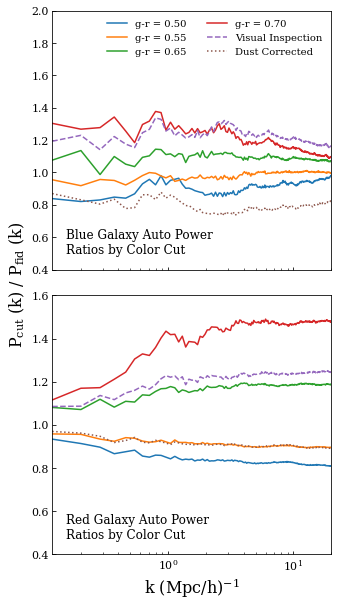

In [172]:
fig, axes = plt.subplots(2, 1, figsize = (5, 10), gridspec_kw = {'hspace':0.1})

p = axes[0]
for b in bdata:
    if b == '0.60':
        lab = 'Dust Corrected'
        ls = ':'
    elif b == 'visual_inspection':
        lab = 'Visual Inspection'
        ls = '--'
    else:
        lab = 'g-r = %s'%b
        ls = '-'
    p.plot(bfid[0], bdata[b], label = lab, linestyle = ls)
p.legend(frameon = False, ncol = 2)
p.set_xscale('log')
p.set_xlim(XLIM)
p.set_ylim([0.4, 2])
p.text(0.05, 0.05, 'Blue Galaxy Auto Power\nRatios by Color Cut',
    ha = 'left', va = 'bottom', transform = p.transAxes,
       fontsize = 12)
p.tick_params(which = 'both', labelbottom = False, direction = 'in',
             labelsize = 11)
p = axes[1]
for r in rdata:
    if r == '0.60':
        lab = 'Dust Corrected'
        ls = ':'
    elif r == 'visual_inspection':
        lab = 'Visual Inspection'
        ls = '--'
    else:
        lab = 'g-r = %s'%r
        ls = '-'
    p.plot(rfid[0], rdata[r], label = lab, linestyle = ls)
# p.legend(frameon = False, ncol = 2)
p.set_xscale('log')
p.set_xlim(XLIM)
p.set_ylim([0.4, 1.6])

p.text(0.05, 0.05, 'Red Galaxy Auto Power\nRatios by Color Cut',
    ha = 'left', va = 'bottom', transform = p.transAxes,
       fontsize = 12)
p.tick_params(which = 'both', direction = 'in', labelsize = 11)
fig.text(0, 0.5, r'P$_{\rm{cut}}$ (k) / P$_{\rm{fid}}$ (k)',
        rotation = 'vertical', va = 'center', ha = 'left', fontsize = 16)
p.set_xlabel('k (Mpc/h)$^{-1}$', fontsize = 16)
fig.savefig("pk_color_ratios_auto.pdf")

The row values for ['color']: ['blue', 'red', 'resolved']
The column values for ['']: ['no key found']


IndexError: list index out of range

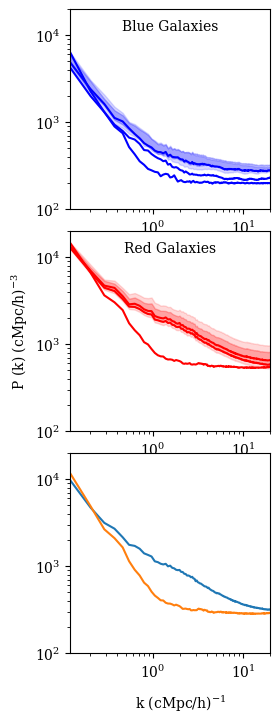

In [153]:
dl = DataList(master.getMatching({'snapshot':99}))
fg = Figrid(dl)
fg.setColOrder(['blue', 'red'])
fg.arrange('color', '', panel_length = 2, xborder = XBORDER, yborder = YBORDER)
fg.makeFills({'color_cut':['0.50', '0.70'], 'color': 'blue'}, {'color':'blue', 'alpha':0.15})
fg.makeFills({'color_cut':['0.55', '0.65', 'visual_inspection'], 'color': 'blue'}, {'color': 'blue', 'alpha':0.25})
fg.makeFills({'color_cut':['0.50', '0.70'], 'color':'red'}, {'color':'red', 'alpha':0.15})
fg.makeFills({'color_cut':['0.55', '0.65', 'visual_inspection'], 'color':'red'}, {'color':'red', 'alpha':0.25})
fg.setPlotArgs({'color_cut':'0.60', 'color':'red'}, {'color':'red'})
fg.setPlotArgs({'color_cut':'0.60', 'color':'blue'}, {'color':'blue'})

fg.plot()

axkw = {}
axkw['xlim'] = XLIM
axkw['yscale'] = 'log'
axkw['xscale'] = 'log'
axkw['ylim'] = [1e2, 2e4]
fg.setAxisParams(axkw)

flib.pklabels(fg)

fg.setRowLabels(['Blue Galaxies', 'Red Galaxies'], [0.5, 0.95], {'va': 'top','ha':'center'})

fg.setDefaultTicksParams()
fg.setTicks({'direction':'in'})

In [12]:
fg.save('colordef_test.png')